In [160]:
import crypten
import torch
import numpy as np
import matplotlib.pyplot as plt
import crypten.mpc as mpc

import sys
sys.path.append("../") # go to parent dir
sys.path.append("../../") # go to parent parent dir
import utils

import time

crypten.init()

torch.set_num_threads(1)
torch.set_printoptions(precision=16) # default

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [199]:
def get_max_indices(x, bits_to_cut):    
    x_copy = x.clone() # to avoid cutting bits on the real input, which is returned at the end
    x_copy_abs = x_copy.abs() # get abs values

    # preparing for argmax:
    # cutting c bits for efficiency reasons
    if bits_to_cut > 0:
        power_of_two = 2 ** bits_to_cut
        #crypten.print(f"Source {0} cutting the bits by div {power_of_two}")
        x_copy_abs = x_copy_abs.div(power_of_two) # removing the last c bits from every share

    #crypten.print(f"Source {0} after cutting bits= {x_copy_abs.get_plain_text()}")
    
    r = x_copy_abs.argmax(one_hot=False)
    return r

In [200]:
@mpc.run_multiprocess(world_size=3)
def distributed_noise_and_round(x1_input, x2_input, x3_input, n, k, c):
    x1 = crypten.cryptensor(x1_input, ptype=crypten.mpc.arithmetic)
    x2 = crypten.cryptensor(x2_input, ptype=crypten.mpc.arithmetic)
    x3 = crypten.cryptensor(x3_input, ptype=crypten.mpc.arithmetic)

    x = crypten.cryptensor(torch.zeros(n), ptype=crypten.mpc.arithmetic)
    for i in range(n):
        x[i] = x1[i] + x2[i] + x3[i]

    argmax = get_max_indices(x, c)

    return argmax.get_plain_text()

In [210]:
counts = {}
n = 100
for c in [0, 10, 20, 22, 25, 30]:
    
    counts[c] = 0
    start = time.time()
    for i in range(100):
        # simulate input from 3 parties
        x1 = torch.tensor(np.random.uniform(-1000, 1000, n))
        x2 = torch.tensor(np.random.uniform(-1000, 1000, n))
        x3 = torch.tensor(np.random.uniform(-1000, 1000, n))

        # Get real argmax:
        x = x1 + x2 + x3
        real_argmax = np.argmax(np.abs(x))

        argmax = distributed_noise_and_round(x1, x2, x3, n, 1, c)
        if argmax[0] != real_argmax:
            counts[c] += 1

    end = time.time()
    print(f'DONE for c={c}, duration={end - start} seconds')


DONE for c=0, duration=139.21102499961853 seconds
DONE for c=10, duration=134.14878821372986 seconds
DONE for c=20, duration=136.08517503738403 seconds
DONE for c=22, duration=135.5628821849823 seconds
DONE for c=25, duration=140.5830500125885 seconds
DONE for c=30, duration=152.22418999671936 seconds


Text(0, 0.5, '% wrong argmax')

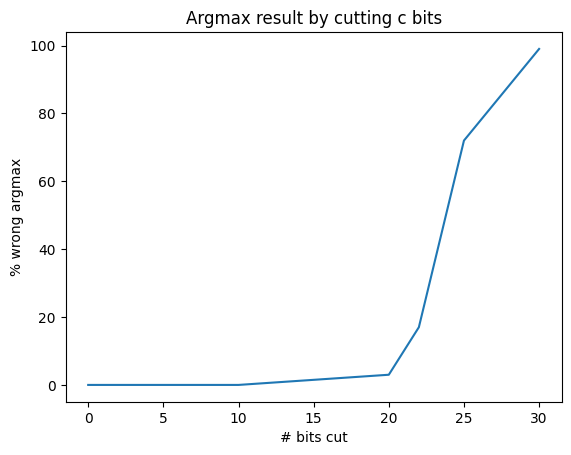

In [211]:
y_values = [counts[k] for k in counts.keys()]

plt.plot([0, 10, 20, 22, 25, 30], y_values)
plt.title('Argmax result by cutting c bits')
plt.xlabel('# bits cut')
plt.ylabel('% wrong argmax')